# Sentiment Analysis on Amazon Fine Food Reviews with RoBerta using Tensorflow


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


In [1]:
!nvidia-smi

Sun Sep  6 12:35:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-897c3450-08ed-b8ae-d662-c948a978372b)


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [97]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from pylab import rcParams
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

!pip install -qq transformers==3.0.0 
!pip install -qq  bert-for-tf2
!pip install -qq sentencepiece

import transformers
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import TFRobertaForSequenceClassification, RobertaConfig, TFRobertaModel

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

rcParams['figure.figsize'] = 14, 10

%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.ERROR)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


## Reading Data

In [8]:
dataset = pd.read_csv('/content/drive/My Drive/bert_amzn/Reviews.csv')
print(dataset.shape)
dataset.head(3)

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## Cleaning Data

### Deduplication

In [10]:
# By inspection we can see that there are many duplicate entries, lets remove these entries from the data
dataset[dataset['UserId'] == 'AR5J8UI46CURR']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
73790,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
78444,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138276,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138316,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
155048,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [11]:
#Sorting data according to ProductId in ascending order
sorted_data=dataset.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(393933, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(dataset['Id'].size*1.0)*100

69.29901100176971

In [14]:
# helpfulness numerator cannot be greater than helpfulness denominator
final[final.HelpfulnessNumerator>final.HelpfulnessDenominator]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(393931, 10)


5    250966
4     56086
1     36307
3     29772
2     20800
Name: Score, dtype: int64

## Class distribution

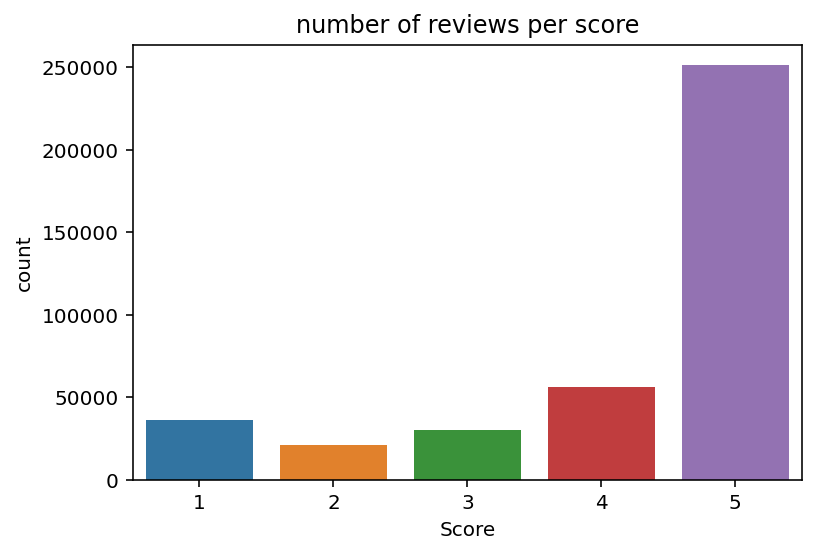

In [18]:
chart = sns.countplot(final.Score)
plt.title("number of reviews per score")
plt.show()

- There is a huge imbalance in the dataset but that's fine since we are going to discard the reviews with a score of 3 and merge the remaining reviews for positive and negative sentiments

In [19]:
# we will remove all the entries with score=3
final = final[final['Score'] != 3]
final.shape

(364159, 10)

In [20]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  else: 
    return 1

In [21]:
final['Score'] = final.Score.apply(to_sentiment)

In [22]:
class_names = ['negative', 'positive']

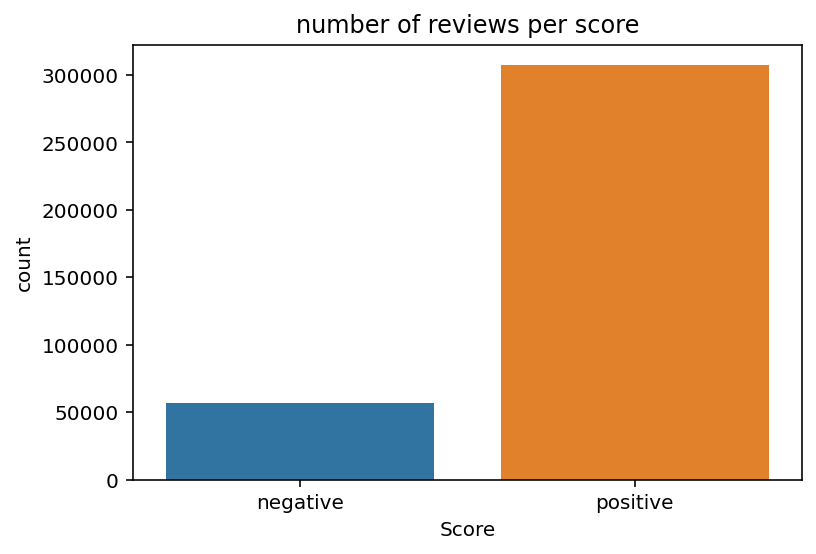

In [23]:
ax = sns.countplot(final.Score)
plt.title("number of reviews per score")
ax.set_xticklabels(class_names)
plt.show()

- After merging the reviews for negative and positive sentiments still there is huge imbalance, to solve this problem we are going to undersample the classes to balance them

In [24]:
# we will select 20000 reviews per class
negative = final[final['Score'] == 0].sample(2000, random_state=RANDOM_SEED)
positive = final[final['Score'] == 1].sample(2000, random_state=RANDOM_SEED)

negative.reset_index(drop=True, inplace=True)
positive.reset_index(drop=True, inplace=True)

final_data = pd.concat([negative, positive]).sample(frac=1).reset_index(drop=True)
final_data.shape

(4000, 10)

In [25]:
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,363818,B001M08YZA,AY13D92T50NP1,"LESA ""nickl shopper""",1,1,0,1347408000,NOW it is Worse,"I want to be clear, this review is about Speci..."
1,21672,B002BCD2GO,A3QLCMDXKQAXQ4,"A. Hollin ""cecret_squirl""",0,0,1,1320105600,Good buy,I had been purchasing this product in the 11 o...
2,558023,B000EM9E2Y,A2P64PMUQVHTY,ValerieZ,0,0,0,1335139200,Disgusting... Wish I could return something I ...,I ordered this item at the same time that I or...


In [26]:
final_data.Score.value_counts()

1    2000
0    2000
Name: Score, dtype: int64

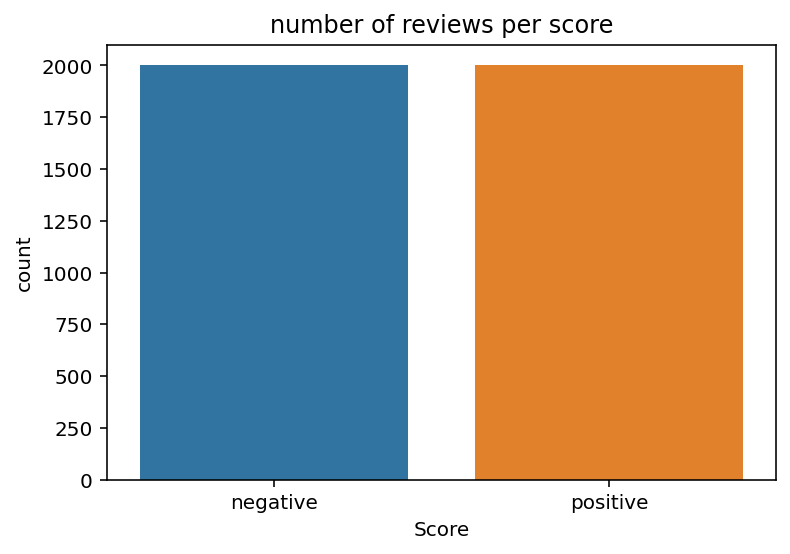

In [27]:
ax = sns.countplot(final_data.Score)
plt.title("number of reviews per score")
ax.set_xticklabels(class_names)
plt.show()

In [28]:
## Text processing

In [31]:
# printing some random reviews
sent_0 = final_data['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final_data['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final_data['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_2000 = final_data['Text'].values[2000]
print(sent_2000)
print("="*50)

I want to be clear, this review is about Special K Protein Plus "Now tastes Even Better". The "original" was great, FIVE STARS!! This one has more than triple the sugar, and is sugary sweet. And it now contains aspartame so it has that awful after-taste. I just cancelled my "subscribe and save" 12 boxes each month. I'm very disappointed. Unless you are looking for "frosted flakes", don't buy this.
This was easy to grow and took only about 2-3 days. My cat liked it and would pick at it throughout the day. However, I would recommend maybe splitting up the seeds so you can make the product last longer. This only lasted me about 1 1/2 weeks and then the grass died. Think I will just buy the seeds from now on and grow in my own pot.
Getting really good cocoa out of a K-cup is not easy but this is much better than the others I have tried. Still a little wattery, but at 60 calories it is a nice treat.  very rich flavor - not as good as the real thing, bit I am not drinking it in a Berlin Choc

In [32]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [33]:
# Combining all the above stundents
preprocessed_text = []
# tqdm is for printing the status bar
for sentance in tqdm(final_data['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split())
    preprocessed_text.append(sentance.strip())

100%|██████████| 4000/4000 [00:01<00:00, 2422.84it/s]


In [34]:
# printing some random reviews
sent_0 = preprocessed_text[0]
print(sent_0)
print("="*50)

sent_1000 = preprocessed_text[1000]
print(sent_1000)
print("="*50)

sent_1500 = preprocessed_text[1500]
print(sent_1500)
print("="*50)

sent_2000 = preprocessed_text[2000]
print(sent_2000)
print("="*50)

i want to be clear this review is about special k protein plus now tastes even better the original was great five stars this one has more than triple the sugar and is sugary sweet and it now contains aspartame so it has that awful after taste i just cancelled my subscribe and save boxes each month i am very disappointed unless you are looking for frosted flakes do not buy this
this was easy to grow and took only about days my cat liked it and would pick at it throughout the day however i would recommend maybe splitting up the seeds so you can make the product last longer this only lasted me about weeks and then the grass died think i will just buy the seeds from now on and grow in my own pot
getting really good cocoa out of a k cup is not easy but this is much better than the others i have tried still a little wattery but at calories it is a nice treat very rich flavor not as good as the real thing bit i am not drinking it in a berlin chocolate shop either put your slippers on sit in f

In [35]:
## check for any null values in the dataset
final_data['Text'].isna().any()

False

In [36]:
final_data['Text'] = preprocessed_text
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,363818,B001M08YZA,AY13D92T50NP1,"LESA ""nickl shopper""",1,1,0,1347408000,NOW it is Worse,i want to be clear this review is about specia...
1,21672,B002BCD2GO,A3QLCMDXKQAXQ4,"A. Hollin ""cecret_squirl""",0,0,1,1320105600,Good buy,i had been purchasing this product in the oz s...
2,558023,B000EM9E2Y,A2P64PMUQVHTY,ValerieZ,0,0,0,1335139200,Disgusting... Wish I could return something I ...,i ordered this item at the same time that i or...


In [37]:
# we will select only text and labels for our final data
final_text_data = pd.DataFrame(columns=['text','labels'])
final_text_data['text'] = final_data['Text']
final_text_data['labels'] = final_data['Score']

In [39]:
# save the final processed data to drive
final_text_data.to_pickle('/content/drive/My Drive/bert_amzn/roberta_reviews.pkl')

In [40]:
# load the data from drive
final_text_data = pd.read_pickle('/content/drive/My Drive/bert_amzn/roberta_reviews.pkl')
final_text_data.shape

(4000, 2)

In [41]:
# splitting data into train, cv and test dataset
train_df, test_df = train_test_split(final_text_data, test_size=0.3, random_state=RANDOM_SEED)
train_df, cv_df = train_test_split(final_text_data, test_size=0.2, random_state=RANDOM_SEED)

In [42]:
# Training data
train_df.reset_index(drop=True, inplace=True)
print(train_df.shape)
train_df.head(3)

(3200, 2)


,text,labels
0,amazon gets stars for handling the box problem...,0
1,i have a lab and a golden retriever lab mix as...,1
2,i love tom ka soup but this mix is not right i...,0


In [43]:
train_df.labels.value_counts()

0    1602
1    1598
Name: labels, dtype: int64

In [44]:
# Testing data
test_df.reset_index(drop=True, inplace=True)
print(test_df.shape)
test_df.head(3)

(1200, 2)


,text,labels
0,i love this fresh mild tasting olive oil made ...,1
1,best one if you are looking for pure st john w...,1
2,the description shows an item weight of lbs bu...,0


In [45]:
test_df.labels.value_counts()

0    616
1    584
Name: labels, dtype: int64

In [46]:
# validation data
cv_df.reset_index(drop=True, inplace=True)
print(cv_df.shape)
cv_df.head(3)

(800, 2)


,text,labels
0,i love this fresh mild tasting olive oil made ...,1
1,best one if you are looking for pure st john w...,1
2,the description shows an item weight of lbs bu...,0


In [47]:
cv_df.labels.value_counts()

1    402
0    398
Name: labels, dtype: int64

In [48]:
max_text_length = len(max(final_data["Text"], key=len).split(' '))
max_text_length ## length of the largest text sample from the dataset

660

In [49]:
f_data = pd.DataFrame()
f_data['len_text'] = final_data['Text'].apply(lambda x: len(x.split()))
f_data = f_data[f_data.len_text > 450]
f_data.shape ## how many text samples are more than 450 in length
## max token length supported by bert is 512 and we have 218 text samples more than 450 words
## we can avoid using truncating and splitting techniques as most of our data is less than 450 words

(12, 1)

## Fine Tuning the Bert Model

### Loading Model

In [54]:
## Loading the bert Model
PRE_TRAINED_MODEL_NAME = 'roberta-base'

In [55]:
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Data preprocessing for Roberta Model

In [56]:
max_length = 512 # max tokens supported by bert
batch_size = 8 # select a lower batch_size to avoid running into memory error

In [57]:
# encoding our text data in a format supported by bert
def convert_example_to_feature(review_text):
  encoding = tokenizer.encode_plus(review_text, # text data 
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
                return_token_type_ids=True,
                truncation = True # truncating reviews longer than the max length
              )
  
  return encoding


In [58]:
# map to the expected input to TFBertForSequenceClassification
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
      }, label

def encode_examples(data):

  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
    
  for review, label in data.to_numpy():

    roberta_input = convert_example_to_feature(review)
  
    input_ids_list.append(roberta_input['input_ids'])
    token_type_ids_list.append(roberta_input['token_type_ids'])
    attention_mask_list.append(roberta_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)


In [59]:
# train dataset
df_train_encoded = encode_examples(train_df).shuffle(train_df.shape[0]).batch(batch_size, drop_remainder=False)

# test dataset
df_test_encoded = encode_examples(test_df).batch(batch_size, drop_remainder=False)

# cv dataset
df_cv_encoded = encode_examples(cv_df).batch(batch_size, drop_remainder=False)

### Roberta Model

In [60]:
# path to save model checkpoints
filepath = '/content/drive/My Drive/bert_amzn/model/model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5' 

# save model to restart training if interrupted and restore the best weights if overfitted
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_freq='epoch')

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

# we will use just 3 epochs since we have enough data
# multiple epochs can be better as long as we do not overfit the model
# recommended epochs are maximum 4-5, since its very easy to overfit bert models
number_of_epochs = 4

# for multiclass classification we need to specify the number of class labels in bert
# for binary clasiification specifying the number of class labels is not necessary
config = RobertaConfig.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=2) 

# model initialization
model = TFRobertaForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, config=config)

# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# compiling the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# print model summary
model.summary()


Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  124645632 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  592130    
Total params: 125,237,762
Trainable params: 125,237,762
Non-trainable params: 0
_________________________________________________________________


### Fitting Model

In [61]:
history = model.fit(df_train_encoded, epochs=number_of_epochs, validation_data=df_cv_encoded, callbacks = [checkpoint])

Epoch 1/4


400/400 [==============================] - ETA: 0s - loss: 0.3419 - accuracy: 0.8512
Epoch 00001: val_loss improved from inf to 0.19913, saving model to /content/drive/My Drive/bert_amzn/model/model-001-0.851250-0.936250.h5
400/400 [==============================] - 752s 2s/step - loss: 0.3419 - accuracy: 0.8512 - val_loss: 0.1991 - val_accuracy: 0.9362
Epoch 2/4
400/400 [==============================] - ETA: 0s - loss: 0.1718 - accuracy: 0.9419
Epoch 00002: val_loss improved from 0.19913 to 0.17822, saving model to /content/drive/My Drive/bert_amzn/model/model-002-0.941875-0.928750.h5
400/400 [==============================] - 750s 2s/step - loss: 0.1718 - accuracy: 0.9419 - val_loss: 0.1782 - val_accuracy: 0.9287
Epoch 3/4
400/400 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 0.9631
Epoch 00003: val_loss did not improve from 0.17822
400/400 [==============================] - 747s 2s/step - loss: 0.1107 - accuracy: 0.9631 - val_loss: 0.2602 - val_accuracy: 0.9

### Accuracy and Loss Plot

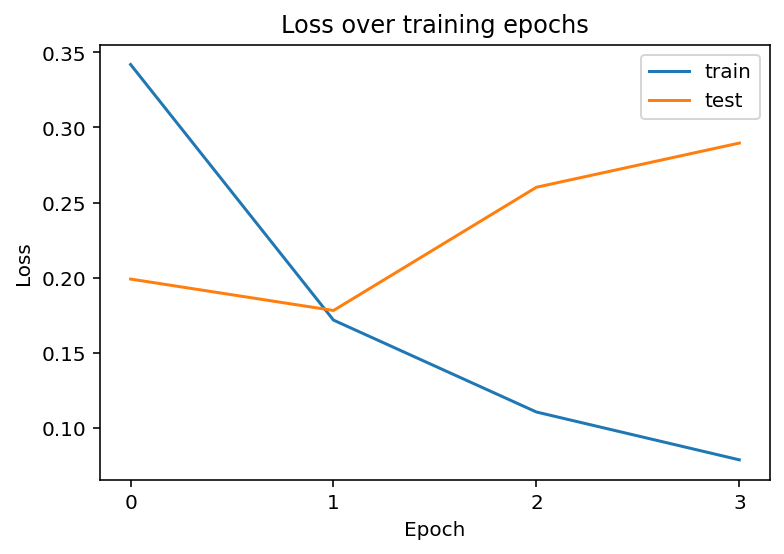

In [62]:
# Loss Plot
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

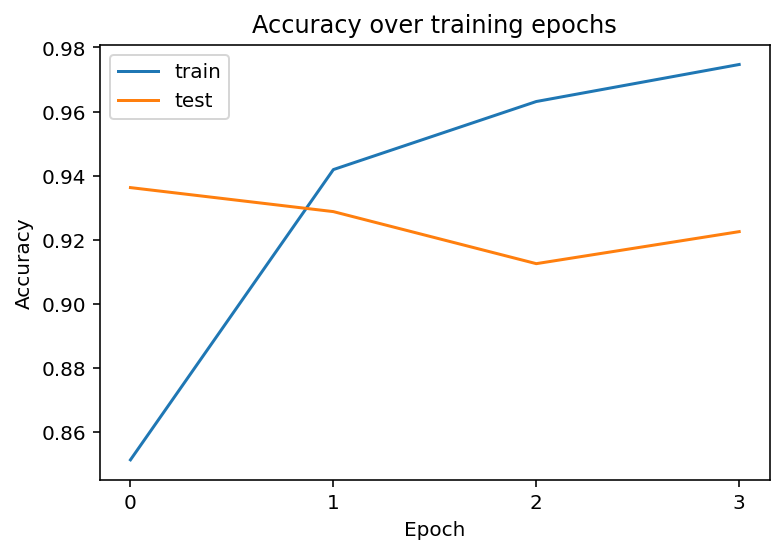

In [63]:
# Accuracy Plot
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

- As we can see from the plots above our model started overfitting just after 2nd epoch

## Evaluating Model on test data

In [65]:
## load best weights for the model
model.load_weights('/content/drive/My Drive/bert_amzn/model/model-002-0.941875-0.928750.h5')

In [66]:
# Evaluating model on test data
score = model.evaluate(df_test_encoded)

print('Test score: ', score[0])
print('Test accuracy: ', score[1])

150/150 [==============================] - 86s 573ms/step - loss: 0.1386 - accuracy: 0.9467
Test score:  0.13860845565795898
Test accuracy:  0.9466666579246521


In [69]:
print(classification_report(test_df.labels, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.95      0.95      0.95       616
    positive       0.95      0.94      0.95       584

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200



## Predictions on test data

In [68]:
predictions = model.predict(df_test_encoded, verbose=1)
y_pred = predictions[0].argmax(axis=-1)

150/150 [==============================] - 86s 570ms/step


In [70]:
cm = confusion_matrix(test_df.labels, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

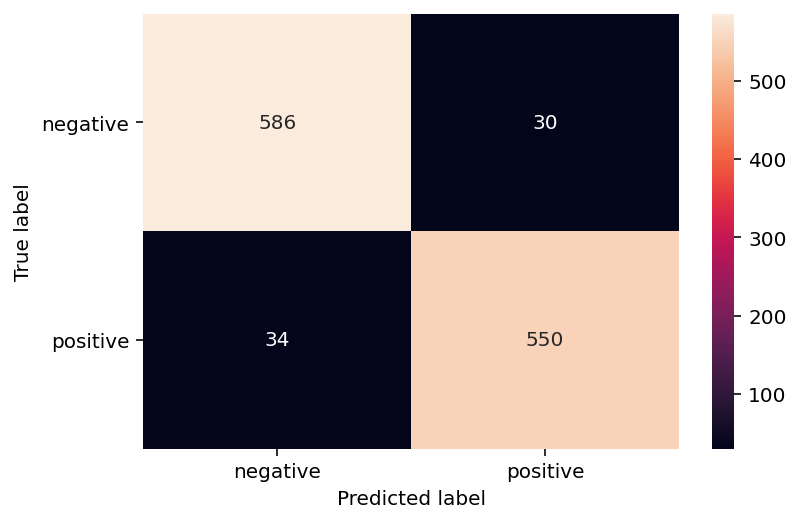

In [71]:
## Confusion matrix
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='center')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Summary

- Here we have used Roberta pretrained model for classification of review texts into positive and negative reviews 
- The roberta text classification model gives 2-20% better results than bert model even with less amount of data
- we have used just 2000 positive and negative reviews each for classification
- We achieved a very High accuracy of 95% on test data even with a training set of just 3200 text reviews